# HR離職預測 分類問題

In [1]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../data/R公司_人員資料_train.csv')
data.head()

,員工編號(EmployeeNumber),性別(Gender),年齡(Age),是否為成年人(Over18),婚姻狀態(MaritalStatus),通勤距離(DistanceFromHome),教育程度(Education),教育專業領域(EducationField),部門(Department),職位名稱(JobRole),...,股票選擇權等級(StockOptionLevel),績效評估(PerformanceRating),出差頻率(BusinessTravel),去年訓練時間(TrainingTimesLastYear),工作滿意度(JobSatisfaction),工作環境滿意度(EnvironmentSatisfaction),工作投入(JobInvolvement),工作生活平衡(WorkLifeBalance),人際關係滿意度(RelationshipSatisfaction),離職(Attrition)
0,1551,Male,24,Y,Divorced,21,2,Technical Degree,Research & Development,Laboratory Technician,...,3,3,Travel_Rarely,3,1,3,2,3,2,No
1,1012,Male,18,Y,Single,5,2,Life Sciences,Research & Development,Research Scientist,...,0,3,Non-Travel,2,4,2,3,3,4,No
2,349,Male,29,Y,Divorced,20,2,Marketing,Sales,Sales Executive,...,1,3,Travel_Rarely,2,4,4,3,3,4,No
3,1654,Male,39,Y,Married,12,3,Medical,Research & Development,Manufacturing Director,...,0,4,Travel_Rarely,3,2,4,3,3,3,No
4,1881,Male,31,Y,Divorced,20,3,Life Sciences,Research & Development,Laboratory Technician,...,1,3,Travel_Rarely,2,3,2,3,3,1,No


In [2]:
#列出欄位名稱
data.columns

Index(['員工編號(EmployeeNumber)', '性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)', '離職(Attrition)'],
      dtype='object')

In [3]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['離職(Attrition)'])

# 自動前處理 (自製)

In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):         
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []
        
    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names       
        
        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數
            
            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()    
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()    
                    self.scaler[fname].fit(data[[fname]])

            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)                    
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)
                
        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()
        
        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])
            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:                   
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass                
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)          

In [5]:
# # AutoPreprocess Example
# ####################################################
# # Train Step
# mydata = pd.read_csv('../data/Automobile_Train.csv')
# ap = AutoPreprocess()
# ap.fit(mydata, ['symboling', 'Normalized-losses', 'make', 'Fuel-type', 'aspiration',
#        'Num-of-doors', 'Body-style', 'Drive-wheels', 'Engine-location',
#        'Wheel-base', 'length', 'width', 'height', 'Curb-weight', 'Engine-type',
#        'Num-of-cylinders', 'Engine-size', 'Fuel-system', 'bore', 'stroke',
#        'Compression-ratio', 'horsepower', 'Peak-rpm', 'City-mpg',
#        'Highway-mpg'])
# ap.save("C:/DATA/test.bin")

# ####################################################
# # Test and inference
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# d2 = ap2.transform(mydata) #Pandas Dataframe
# d2.head()

# ####################################################
# # Test and inference with one record
# ap2 = AutoPreprocess.load("C:/DATA/test.bin")
# data_dict = {"symboling":1, "aspiration":"std"}
# d2 = ap2.transform(data_dict) #Python Dict
# print(d2)


# 前處理

In [12]:
ap = AutoPreprocess()
ap.fit(data, ['性別(Gender)', '年齡(Age)', '是否為成年人(Over18)',
       '婚姻狀態(MaritalStatus)', '通勤距離(DistanceFromHome)', '教育程度(Education)',
       '教育專業領域(EducationField)', '部門(Department)', '職位名稱(JobRole)',
       '職位等級(JobLevel)', '在該公司工作總年資(YearsAtCompany)',
       '在該職位工作年資(YearsInCurrentRole)', '在該職等工作年資(YearsSinceLastPromotion)',
       '與現任管理者工作年資(YearsWithCurrManager)', '總工作年資(TotalWorkingYears)',
       '過去工作公司家數(NumCompaniesWorked)', '每日工資額(DailyRate)',
       '每小時工資額(HourlyRate)', '月收入(MonthlyIncome)', '月費率(MonthlyRate)',
       '標準工作時間(StandardHours)', '加班(OverTime)', '調薪百分比(PercentSalaryHike)',
       '股票選擇權等級(StockOptionLevel)', '績效評估(PerformanceRating)',
       '出差頻率(BusinessTravel)', '去年訓練時間(TrainingTimesLastYear)',
       '工作滿意度(JobSatisfaction)', '工作環境滿意度(EnvironmentSatisfaction)',
       '工作投入(JobInvolvement)', '工作生活平衡(WorkLifeBalance)',
       '人際關係滿意度(RelationshipSatisfaction)'])
ap.save("C:/DATA/preprocess.bin")

X = ap.transform(data)
y = data['離職(Attrition)'].map({'Yes': 1, 'No': 0})


# 訓練模型 : 方法一

In [13]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [39]:
# 訓練模型
from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier()

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(200,50))

# from sklearn.svm import SVC
# model = SVC()

model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 50))

In [36]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
y_pred = model.predict(X_train)
score = roc_auc_score(y_train, y_pred)
print("訓練組AUC :", score)
score = recall_score(y_train, y_pred)
print("訓練組recall :", score)
score = precision_score(y_train, y_pred)
print("訓練組precision :", score)

# plt.scatter(y_train, y_pred, alpha=0.6, color='b')
# # plt.show()

y_pred = model.predict(X_valid)
score = roc_auc_score(y_valid, y_pred)
print("驗證組AUC:", score)
score = recall_score(y_valid, y_pred)
print("驗證組recall:", score)
score = precision_score(y_valid, y_pred)
print("驗證組precision:", score)


訓練組AUC : 0.6926502732240438
訓練組recall : 0.38666666666666666
訓練組precision : 0.9830508474576272
驗證組AUC: 0.5896849593495934
驗證組recall: 0.1875
驗證組precision: 0.8181818181818182


驗證組AUC: 0.6902947154471545
驗證組recall: 0.4375
驗證組precision: 0.6


Text(50.722222222222214, 0.5, 'Actual Values ')

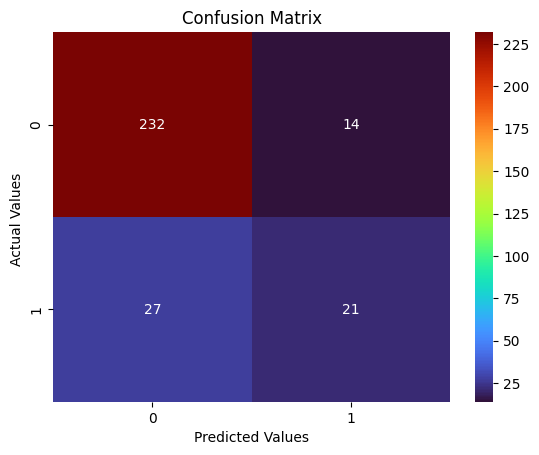

In [40]:
threshold = 0.5
y_pred = (model.predict_proba(X_valid)[:,1] > threshold).astype('int')
score = roc_auc_score(y_valid, y_pred)
print("驗證組AUC:", score)
score = recall_score(y_valid, y_pred)
print("驗證組recall:", score)
score = precision_score(y_valid, y_pred)
print("驗證組precision:", score)

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = (confusion_matrix(y_valid, y_pred))

fx = sns.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='d')

fx.set_title('Confusion Matrix')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ')

驗證組AUC: 0.6902947154471545
驗證組recall: 0.4375
驗證組precision: 0.6


Text(50.722222222222214, 0.5, 'Actual Values ')

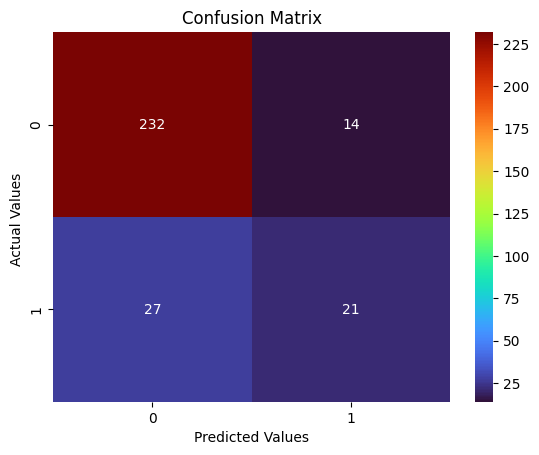

In [44]:
threshold = 0.5
y_pred = (model.predict_proba(X_valid)[:,1] > threshold).astype('int')
score = roc_auc_score(y_valid, y_pred)
print("驗證組AUC:", score)
score = recall_score(y_valid, y_pred)
print("驗證組recall:", score)
score = precision_score(y_valid, y_pred)
print("驗證組precision:", score)

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = (confusion_matrix(y_valid, y_pred))

fx = sns.heatmap(conf_matrix, annot=True, cmap='turbo', fmt='d')

fx.set_title('Confusion Matrix')
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ')

In [45]:
#儲存模型
import pickle

with open("C:/DATA/model.bin", "wb") as f:
    pickle.dump(model, f)


# 評估欄位影響度 Permutation Importance

In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score


def getFieldImpact(model, x, y, score):
    prediction = model.predict(x)
    full_field_score = score(y, prediction)
    impact = {}
    for column_name in x.columns:
        x2 = x.copy()
        column_data = x2[column_name].to_numpy()
        np.random.shuffle(column_data)
        x2[column_name] = column_data
        p2 = model.predict(x2)
        score2 = score(y, p2)
        impact[column_name] = (full_field_score - score2) / full_field_score
    return impact

    
    
impact = getFieldImpact(model, X, y, roc_auc_score)
impact

{'性別(Gender)_Male': -0.0016251989612129588,
 '性別(Gender)_Female': 0.02295384099857603,
 '年齡(Age)': 0.08742565133618165,
 '是否為成年人(Over18)_Y': 0.0,
 '婚姻狀態(MaritalStatus)_Married': 0.002731004439976621,
 '婚姻狀態(MaritalStatus)_Single': 0.018011225601072444,
 '婚姻狀態(MaritalStatus)_Divorced': 0.038267571416603904,
 '通勤距離(DistanceFromHome)': 0.04542179777163446,
 '教育程度(Education)': 0.001105805478763542,
 '教育專業領域(EducationField)_Life Sciences': 0.004389712658121874,
 '教育專業領域(EducationField)_Medical': 0.005462008879953242,
 '教育專業領域(EducationField)_Marketing': 0.012029823238669786,
 '教育專業領域(EducationField)_Technical Degree': 0.008193013319929623,
 '教育專業領域(EducationField)_Other': -0.0016251989612129588,
 '教育專業領域(EducationField)_Human Resources': 0.006014911619334953,
 '部門(Department)_Research & Development': 0.0,
 '部門(Department)_Sales': 0.011476920499287955,
 '部門(Department)_Human Resources': -0.000552902739381831,
 '職位名稱(JobRole)_Sales Executive': 0.003283907179358332,
 '職位名稱(JobRole)_Research Sc